## Chatper 4 분류

### 4. 랜덤 포레스트

#### 랜덤 포레스트의 개요 및 실습
랜덤 포레스트는 배깅(bagging)의 대표적인 알고리즘으로 속도도 빠르고 예측 성농도 좋다. 기반 알고리즘은 결정 트리로써 결정 트리의 쉽고 직관적인 장점을 그래도 가지고 있다.
랜덤 포레스트는 여러 개의 결정 트리 분류기가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해 개별적으로 학습한 뒤 모든 분류기가 보팅을 통해 예측 결정을 하게 된다.
랜덤 포레스트는 개별적인 분류기의 기반 알고리즘은 결정 트리이지만, 개별 트리가 학습하는 데이터 세트는 전체 데이터 세트에서 일부가 중첩되게 샘플링된 데이터 세트이다. 이렇게 여러 데이터가 중첩되게 분리하는 것을 부트스트래핑(bootstrapping) 분할 방식이라고 한다. 랜덤 포레스트의 서브 세트 데이터의 수는 전체 데이터 세트의 수와 같지만 개별 데이터가 중첩되어 만들어진다.

In [1]:
# 랜덤 포레스트 실습을 위한 데이터셋 불러오기
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./data/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data/human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도 : 0.9253


#### 랜덤 포레스트 하이퍼 파라미터 및 튜닝

일반적으로 트리 기반의 앙상블 알고리즘의 단점은 하이퍼 파라미터가 너무 많고, 그로 인해 튜닝을 위한 시간이 많이 소요된다는 점이다. 그럼에도 불구하고 예측 성능이 크게 좋아지는 경우는 많지 않다.
그나마 랜덤 포레스트는 적은 편에 속하며 결정 트리에서 사용하는 하이퍼 파라미터와 같은 파라미터가 대부분이다.

- n_estimators : 결정 트리의 개수를 지정, 디폴트는 10이며 많이 설정할수록 좋은 성능 기대 가능 vut 항상 향상은 아니며 학습 수행 시간도 늘어남
- max_features : 결정 트리의 max_features와 같다. 기본값은 'auto', 즉, 'sqrt'와 같다. 따라서 랜덤 포레스트의 트리를 분할하는 피처를 참조할 때 sqrt(전체 피처 개수)만큼만 참조
- max_depth나 min_smaples_leaf와 같은 결정 트리에서 과적합 개선을 위한 파라미터도 똑같이 사용 가능

In [3]:
# GridSearchCV를 이용해 최적의 하이퍼 파라미터를 찾아보자.


from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [4]:
# n_estimators를 300으로 늘려 최적의 하이퍼 파라미터 조합과 RandomForestClassifier를 학습시킨 뒤
# 별도의 테스트 데이터 세트에서 예측 성능을 측정해보자.

rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, \
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.9165


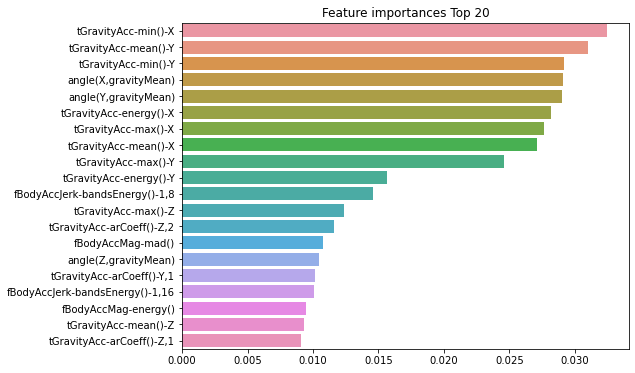

In [5]:
# RandomForestClassifier도 결정 트리와 같이 feature_importances_ 속성을 이용해 피처의 중요드를 알 수 있다.

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

### 5. GBM(Gradient Boosting Machine)

#### GBM의 개요 및 실습
부스팅 알고리즘은 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식이다.
대표적으로 AdaBoost와 그래디언트 부스트가 있다.
AdaBoost는 각 Step마다 잘못 예측한 데이터에 가중치를 부여하며 학습을 진행해 나가며 GBM과의 차이점은 GBM은 가중치 업데이트를 경사 하강버을 이용하는 것이 큰 차이이다. 오류 값은 실제 값 - 예측으로 계산한다.
GBM은 회귀도 가능하다.

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train , y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

GBM 정확도: 0.9389
GBM 수행 시간: 921.6 초 


일반적으로는 랜덤 포레스트보다 성능이 뛰어난 경우가 많다. 그러나 수행 시간이 오래 걸리며 하이퍼 파라미터 튜닝 노력도 필요하다.

#### GBM 하이퍼 파라미터 및 튜닝

n_estimators, max_depth, max_features와 같은 트리 기반 자체의 파라미터는 앞에서 나왔으니 생략

- loss : 경사 하강법에서 사용할 비용 함수 지정. 기본값은 'deviance'
- learning_rate : 학습률이며 0~1 값 지정 가능하다. 0.1이 기본값이다. 학습률의 특성 상 n_estimators와 상호 보완적으로 조합해 사용한다. (학습률 작게, n_estimators 크게 but 시간 오래걸림)
- n_estimators : weak learner의 개수이며 기본값은 100이다.
- subsample : weak learner가 사용하는 데이터의 샘플링 비율. 기본 값은 1이며 이는 전체 학습 데이터를 기반으로 학습한다는 의미이다. 과적합이 염려되면 1보다 작게 설정하자.

In [7]:
# 하이퍼 파라미터 튜닝

from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 145.6min finished


최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 500}
최고 예측 정확도: 0.9011


In [8]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.9420


### 6. XGBoost(eXtra Gradient Boost)

#### XGBoost 개요

XGBoost는 압도적 수치 차이는 아니지만 일반적으로 다른 머신러닝보다 뛰어난 성능을 보인다. GBM에 기반하고 있지만 느린 수행 시간을 해결했으며 (병렬 CPU 작업 가능 하지만 다른 알고리즘에 비해서는 빠르진 않다.) 과적합 규제 부재 등의 문제를 해결했다.
독자적 프레임워크 기반의 XGBoost를 파이썬 래퍼 XGBoost 모듈, 사이킷런과 연동되는 모듈을 사이킷런 래퍼 XGBoost 모듈이라고 지칭하자.

#### 파이썬 래퍼 XGBoost 하이퍼 파라미터

파이썬 래퍼 XGBoost 하이퍼 파라미터를 유형별로 나누면 다음과 같다.
- 일반 파라미터 : 일반적으로 실행 시 디폴트 파라미터 값을 바꾸는 일이 거의 없음
- 부스트 파라미터 : 트리 최적화, 부스팅, regularization 등과 관련 파라미터 등을 지칭한다.
- 학습 태스크 파라미터 ; 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정한다.

##### 주요 일반 파라미터
- booster : gbtree 또는 gblinear 선택. 디폴트는 gbtree
- silent : 디폴트는 0이며 출력 메시지를 나타내고 싶지 않으면 1로 지정
- nthread : 스레드 개수 조절 디폴트는 전체 스레드 모두 사용

##### 주요 부스터 파라미터
- eta : GBM의 학습률과 같은 파라미터. 0과 1 사이의 값을 지정. 디폴트는 0.3이다. 보통은 0.01 ~ 0.2 값 선호. 사이킷런 래퍼 XGBoost에서는 learning_rate로 대체
- num_boost_rounds : GBM의 n_estimators와 같음
- min_child_weight : 트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요한 데이터들의 weight 총합. 클수록 분할을 자제한다. 디폴트는 1, 과적합 조절을 위해 사용한다.
- gamma : 트리의 리프 노드를 추가적으로 나눌지를 결정ㅎ알 최소 손실 감소 값. 해당 값보다 큰 손실이 감소된 경우 분리. 값이 클수록 가적합 감소 효과, 디폴트는 0 사이킷런 래퍼 클래스를 이용할 경우 min_split_loss로 대체
- max_depth : 디폴트는 6이다. 보통은 3-10 사이 값 사용
- sub_sample : GBM의 subsample과 동일 디폴트는 1이다. 일반적으로 0.5~1 사이 값 사용
- colsample_bytree : GBM의 max_features와 유사. 디폴트는 1이다. 트리 생성에 필요한 피처를 임의로 샘플링하는데 사용 과적합 제어 
- lambda : L2 Regulation 적용 값, 디폴트는 1 사이킷런 연동에서는 reg_lambda로 대체
- alpha : L1 Regulation 적용 값, 디폴트는 0, reg_alpha로 대체
- scale_pos_weight : 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파리미터로 디폴트는 1이다.

##### 학습 태스크 파라미터
- objective : 최솟값을 가져야 할 손실함수 정의
    - binary:logistic : 이진분류일 때 적용
    - multi:softmax : 다중 분류일 때 적용
    - multi:softprob : 개별 레이블 클래스의 해당되는 예측 확률 반환
- eval_metric : 검증에 사용되는 함수 정의. 기본값은 회귀일 경우 rmse, 분류일 경우 error
    - rmse : Root Mean Square Error
    - mae : Mean Absolute Error
    - logloss : Negative log-likelihood
    - error : Binary classification error rate (0.5 threshold)
    - merror : Multiclass classification error rate
    - mlogloss : Multiclass logloss
    - auc : Area under the curve
    
과적합이 심하다면?
- eta 값을 낮춘다. (num_round 또는 n_estimators는 반대로 높여야 한다.)
- max_depth 값을 낮춘다.
- min_child_weight 값으르 높인다.
- gamma 값을 높인다.
- subsample, colsample_bytree를 조정하는 것도 도움이 된다.

#### 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측

In [9]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [10]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [11]:

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )
print(X_train.shape , X_test.shape)

(455, 30) (114, 30)


In [12]:
# 학습용과 테스트용 데이터 세트를 위해 별도의 객체 DMatrix 생성 (주로 넘파이 입력 파라미터)
dtrain = xgb.DMatrix(data=X_train , label=y_train)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [13]:
params = { 'max_depth':3,
           'eta': 0.1,
           'objective':'binary:logistic',
           'eval_metric':'logloss'
        }
num_rounds = 400

In [14]:
# train 데이터 셋은 ‘train’ , evaluation(test) 데이터 셋은 ‘eval’ 로 명기합니다. 
wlist = [(dtrain,'train'),(dtest,'eval') ]

# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
# 조기중단을 위한 최소 반복 횟수 : early_stopping_rounds 파라미터
# evals에는 학습 데이터 세트와 eval 데이터 세트를 명기. 평가를 eval에 수행하며
# 조기중단 적용이 가능해짐
# train()은 학습이 완료된 모델 객체를 반환한다.
xgb_model = xgb.train(params = params , dtrain=dtrain , num_boost_round=num_rounds , \
                      early_stopping_rounds=100, evals=wlist )

[0]	train-logloss:0.609688	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540803	eval-logloss:0.547842
[2]	train-logloss:0.483753	eval-logloss:0.494247
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354145	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292592	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207937	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logl

[161]	train-logloss:0.007261	eval-logloss:0.088013
[162]	train-logloss:0.007241	eval-logloss:0.087758
[163]	train-logloss:0.007221	eval-logloss:0.087784
[164]	train-logloss:0.0072	eval-logloss:0.087777
[165]	train-logloss:0.00718	eval-logloss:0.087517
[166]	train-logloss:0.007161	eval-logloss:0.087542
[167]	train-logloss:0.007142	eval-logloss:0.087642
[168]	train-logloss:0.007122	eval-logloss:0.08739
[169]	train-logloss:0.007103	eval-logloss:0.087377
[170]	train-logloss:0.007084	eval-logloss:0.087298
[171]	train-logloss:0.007065	eval-logloss:0.087368
[172]	train-logloss:0.007047	eval-logloss:0.087395
[173]	train-logloss:0.007028	eval-logloss:0.087385
[174]	train-logloss:0.007009	eval-logloss:0.087132
[175]	train-logloss:0.006991	eval-logloss:0.087159
[176]	train-logloss:0.006973	eval-logloss:0.086955
[177]	train-logloss:0.006955	eval-logloss:0.087053
[178]	train-logloss:0.006937	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.086973
[180]	train-logloss:0.006901	eval-log

In [15]:
# 예측
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [16]:
# chapter 3에서 사용한 평가 함수

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
    
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


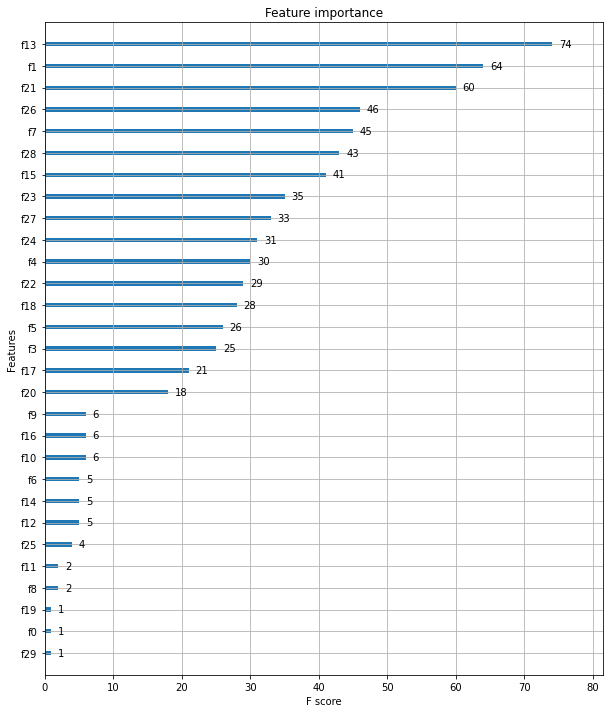

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# 피처 중요도 시각화
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

#### 사이킷런 래퍼 XGBoost의 개요 및 적용

XGBoost 개발 그룹은 사이킷런의 프레임워크와 연동하기 위해 전용 XGBoost 래퍼 클래스를 개발했다. fit, predict()와 GridSearchCV, pipeline 등 사이킷런의 다른 유틸리티를 그대로 사용 가능하다.
하이퍼 파라미터 몇 개는 다음과 같이 변경된다.
- eta => learning_rate
- sub_sample => subsample
- lambda => reg_lambda
- alpha => reg_alpha
또한, n_estimtors와 num_boost_round 하이퍼 파라미터는 서로 동일한 파라미터다.

In [18]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [19]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


In [20]:
# 조기 중단도 수행 가능하다.

# early_stopping_rounds를 10으로 설정하고 재 학습. 
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, 
                eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


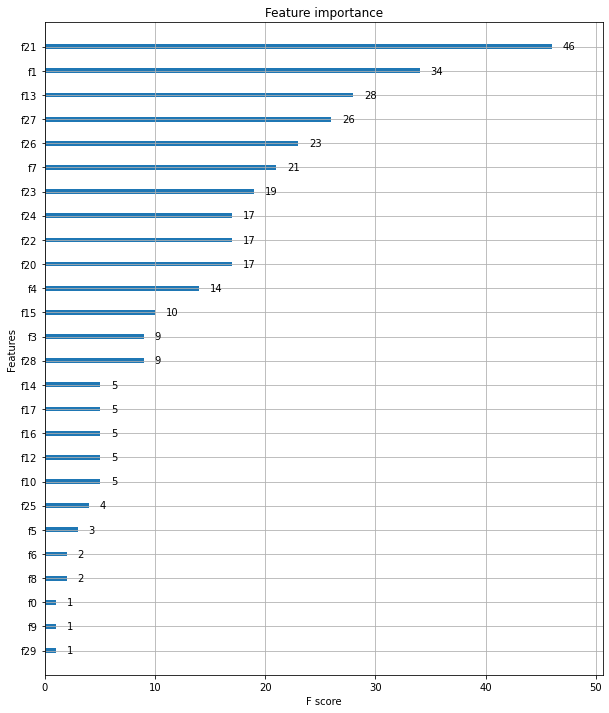

In [21]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)

### 7. LightGBM

LightGBM의 가장 큰 장점은 XGBoost보다 학습에 걸리는 시간이 적다는 점이다. 예측 성능 또한 비슷하며 기능상의 다양성은 약간 더 많다. 단점은 적은 데이터 세트에서 과적합이 발생하기 쉽다는 점이다. (10000건 이하)

![leafwise](./images/leafwise.png)

LightGBM은 일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할 방식을 이용한다. 트리의 균형을 맞추지 않고, 최대 손실 값을 가지는 리프 노드를 지속적으로 분할하며 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성된다.
한편, LightGBM의 XGBoost 대바 장점은 다음과 같다. 
- 더 빠른 학습과 예측 수행 시간
- 더 작은 메모리 사용량
- 카테고리형 피처의 자동 변환과 최적 분할

#### LightGBM 하이퍼 파라미터

XGBoost와 많은 부분이 유사하지만, 리프 노드가 다르게 분할되면서 트리의 깊이가 깊어지므로 이러한 트리 특성에 맞는 하이퍼 파라미터 설정이 필요하다.

- num_iterations : 반복 수행하려는 트리의 개수 지정, 디폴트는 100이다. 크게 지정할수록 성능이 높아질 수 있지만 과적합 가능성 사이킷런 호환 클래스에서는 n_estimators로 사용
- learning_rate : 학습률, 디폴트는 0.1, 0~1값 사용
- max_depth : 디폴트는 -1로, 0보다 작은 값 사용시 깊이에 제한이 없다. LightGBM은 Leafwise이기에 깊이가 상대적으로 더 깊다.
- min_data_in_leaf : 결정 트리의 min_samples_leaf와 같다. 디폴트는 20. 사이킷런 호환 클래스에서는 min_child_samples로 사용
- num_leaves : 하나의 트리가 가질 수 있는 최대 리프 개수, 디폴트는 31
- boosting : 부스팅의 트리를 생성하는 알고리즘 기술, 디폴트는 gbdt
    - gbdt : 일반적은 그래디언트 부스팅 결정 트리
    - rf : 랜덤 포레스트
- bagging_fraction : 트리가 커져서 과적합되는 것을 제어하기 위해서 세이터를 샘플링하는 비율을 지정한다. 사이킷런 호환 클래스에서는 subsample로 사용
- feature_fraction : 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율, 과적합을 막기 위해 사용, 디폴트는 1.0 GBM의 max_features와 유사, 사이킷런 호환 클랫에서는 colsample_bytree로 변경
- lambda_l2 : 디폴트는 0.0, l2규제를 위한 값
- lambda_l1 : 디폴트는 0.0, l1규제를 위한 값
- objective : 최솟값을 가져야 할 손실함수 정의, XGBoost의 objective 파라미터와 동일

#### 하이퍼 파라미터 튜닝 방안

num_leaves의 개수를 중심으로 min_child_samples, max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안이다.

- num_leaves는 개별 트리가 가질 수 있는 최대 리프 개수이고 모델 복잡도를 제어하는 주요 파라이터이다. 개수가 크면 정확도가 높아지지만 과적합 영향도가 커진다.
- min_data_in_leaf는 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지한다.
- max_depth는 명시적으로 깊이의 크기를 제한한다.

학습률을 작게하면서 n_estimators를 크게 하는 것은 가장 기본적인 튜닝 방안이므로 이를 적용하는 것도 좋다. 이 외에도 다른 방법들을 적용할 수도 있다.

In [1]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(ftr, target, test_size=0.2, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정. 
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능. 
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_loglo

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 평가 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

# 평가
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 1 76]]
정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870,    F1: 0.9682, AUC:0.9905


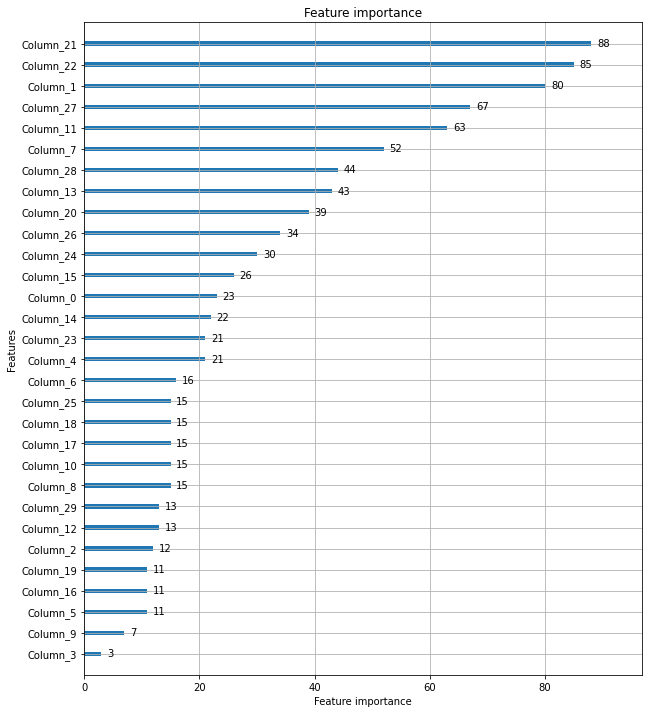

In [3]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)